# 03 — Machine Learning (Regression & Classification)
- feature prep & scaling
- TF models
- evaluation (MAE/R², confusion matrix, ROC AUC)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, classification_report
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv("/Users/amlim/cycling-effectiveness/data/cleaned_cycling.csv")


In [2]:
df.head(20)

,Activity Type,Date,Distance,Calories,Duration,Avg HR,Max HR,Avg Speed,Max Speed,Elev Gain,...,Avg Bike Cadence,Max Bike Cadence,Normalized Power® (NP®),Training Stress Score,Max Avg Power (20 min),Power,Max Power,Time,Session Type,Time of Day
0,indoor_cycling,12/3/2018,25.91,696.0,1:16:35,164.0,180,20.3,23.9,--,...,89,102,158,66.8,163,152,404,5:54,Indoors,Morning
1,road_biking,12/2/2018,20.81,679.0,1:21:12,162.0,190,15.4,27.2,105,...,--,--,--,0.0,--,--,--,13:47,Outdoors,Afternoon
2,road_biking,11/22/2018,46.22,1158.0,2:49:48,158.0,192,16.3,26.1,276,...,83,110,140,116.8,155,114,592,7:44,Outdoors,Morning
3,indoor_cycling,11/18/2018,23.27,634.0,1:18:54,149.0,167,17.7,28.1,--,...,84,104,143,55.9,150,134,321,8:36,Indoors,Morning
4,indoor_cycling,11/18/2018,12.21,512.0,1:00:30,160.0,188,12.1,23.2,--,...,85,109,176,65.3,189,143,675,7:29,Indoors,Morning
5,indoor_cycling,11/17/2018,17.04,490.0,1:18:27,156.0,197,13.0,24.8,--,...,82,114,163,72.4,185,105,513,7:50,Indoors,Morning
6,indoor_cycling,11/14/2018,22.22,696.0,1:16:42,162.0,194,17.4,25.6,--,...,86,112,168,75.6,176,151,552,18:46,Indoors,Evening
7,indoor_cycling,11/11/2018,20.44,605.0,1:16:32,153.0,190,16.0,26.3,--,...,85,109,152,61.4,152,132,528,16:06,Indoors,Afternoon
8,indoor_cycling,11/8/2018,27.88,862.0,1:56:22,152.0,185,14.4,27.7,--,...,81,112,148,89.3,162,124,727,5:29,Indoors,Morning
9,indoor_cycling,11/5/2018,10.20,311.0,35:07:00,161.0,179,17.4,22.3,33,...,85,102,156,29.7,158,148,378,5:49,Indoors,Morning


In [3]:
def clean_numeric_column(df, cols):
    """
    Cleans numeric columns in a DataFrame:
    - Removes commas
    - Replaces '--' with NaN
    - Converts to float
    """
    if isinstance(cols, str):
        cols = [cols]   # allow single column name
    
    for col in cols:
        df[col] = (
            df[col].astype(str)                # ensure string
                  .str.replace(",", "", regex=False)  # remove commas
                  .replace("--", np.nan)       # replace placeholder
                  .replace("nan", np.nan)      # just in case
                  .astype(float)               # convert to float
        )
    return df

In [4]:
df = clean_numeric_column(df, ["Calories", "Avg HR", "Avg Speed"])

In [5]:
if "Session_Type" not in df.columns and "Activity Type" in df.columns:
    def classify_session(activity):
        return "Indoors" if activity in ["indoor_cycling", "virtual_ride"] else "Outdoors"
    df["Session Type"] = df["Activity Type"].apply(classify_session)

In [6]:
if "Training Stress Score®" in df.columns and "Training_Stress_Score" not in df.columns:
    df.rename(columns={"Training Stress Score®": "Training Stress Score"}, inplace=True)

In [7]:
df.head(10)

,Activity Type,Date,Distance,Calories,Duration,Avg HR,Max HR,Avg Speed,Max Speed,Elev Gain,...,Avg Bike Cadence,Max Bike Cadence,Normalized Power® (NP®),Training Stress Score,Max Avg Power (20 min),Power,Max Power,Time,Session Type,Time of Day
0,indoor_cycling,12/3/2018,25.91,696.0,1:16:35,164.0,180,20.3,23.9,--,...,89,102,158,66.8,163,152,404,5:54,Indoors,Morning
1,road_biking,12/2/2018,20.81,679.0,1:21:12,162.0,190,15.4,27.2,105,...,--,--,--,0.0,--,--,--,13:47,Outdoors,Afternoon
2,road_biking,11/22/2018,46.22,1158.0,2:49:48,158.0,192,16.3,26.1,276,...,83,110,140,116.8,155,114,592,7:44,Outdoors,Morning
3,indoor_cycling,11/18/2018,23.27,634.0,1:18:54,149.0,167,17.7,28.1,--,...,84,104,143,55.9,150,134,321,8:36,Indoors,Morning
4,indoor_cycling,11/18/2018,12.21,512.0,1:00:30,160.0,188,12.1,23.2,--,...,85,109,176,65.3,189,143,675,7:29,Indoors,Morning
5,indoor_cycling,11/17/2018,17.04,490.0,1:18:27,156.0,197,13.0,24.8,--,...,82,114,163,72.4,185,105,513,7:50,Indoors,Morning
6,indoor_cycling,11/14/2018,22.22,696.0,1:16:42,162.0,194,17.4,25.6,--,...,86,112,168,75.6,176,151,552,18:46,Indoors,Evening
7,indoor_cycling,11/11/2018,20.44,605.0,1:16:32,153.0,190,16.0,26.3,--,...,85,109,152,61.4,152,132,528,16:06,Indoors,Afternoon
8,indoor_cycling,11/8/2018,27.88,862.0,1:56:22,152.0,185,14.4,27.7,--,...,81,112,148,89.3,162,124,727,5:29,Indoors,Morning
9,indoor_cycling,11/5/2018,10.20,311.0,35:07:00,161.0,179,17.4,22.3,33,...,85,102,156,29.7,158,148,378,5:49,Indoors,Morning


## ML and Regression

In [8]:
if "Duration_min" not in df.columns and "Duration" in df.columns:
    def parse_duration(val):
        try:
            parts = val.split(":")
            if len(parts) == 2:
                val = "00:" + val
            return pd.to_timedelta(val).total_seconds() / 60
        except:
            return None

    df["Duration_min"] = df["Duration"].astype(str).apply(parse_duration)

df = df.dropna(subset=["Duration_min"])

In [9]:
if "Calories_per_min" not in df.columns:
    df["Calories_per_min"] = df["Calories"] / df["Duration_min"]
if "Training_Stress_Score" in df.columns and "TSS_per_min" not in df.columns:
    df["TSS_per_min"] = df["Training_Stress_Score"] / df["Duration_min"]

In [16]:
if "High_Effectiveness" not in df.columns:
    thr = df["Calories_per_min"].quantile(0.75)
    df["High_Effectiveness"] = (df["Calories_per_min"] >= thr).astype(int)
if "Session_Type" in df.columns and df["Session_Type"].dtype == "object":
    df = pd.get_dummies(df, columns=["Session_Type"], drop_first=True)
if "Time_of_Day" in df.columns and df["Time_of_Day"].dtype == "object":
    df = pd.get_dummies(df, columns=["Time_of_Day"], drop_first=True)


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# If you haven't already in a prior cell, ensure df exists:
# df = pd.read_csv("../data/cleaned_cycling.csv")

# If you did one-hot encoding in earlier cells on df, great.
# Now create a modeling copy:
df_ml = df.copy()

# --- Build feature list safely from what actually exists ---
num_feats = [
    "Duration_min", "Distance", "Avg HR", "Avg Speed",
    "Avg Bike Cadence", "Max HR", "Max Speed",
    "Power", "Max Power", "Max Avg Power (20 min)",
    "Elev Gain", "Elev Loss", "Training_Stress_Score"
]
num_feats = [c for c in num_feats if c in df_ml.columns]

# One-hot (dummy) columns that may exist (Afternoon is implicit baseline)
dummy_feats = [
    "Session_Type_Outdoors",
    "Time_of_Day_Morning",
    "Time_of_Day_Evening"
]
dummy_feats = [c for c in dummy_feats if c in df_ml.columns]

X_cols = num_feats + dummy_feats
print("Using features:", X_cols)

# Targets
if "Calories_per_min" not in df_ml.columns:
    raise ValueError("Calories_per_min not found. Compute it before this step.")
y_reg = df_ml["Calories_per_min"]

if "High_Effectiveness" not in df_ml.columns:
    # create label here if your cleaned file doesn't have it yet
    thr = y_reg.quantile(0.75)
    df_ml["High_Effectiveness"] = (y_reg >= thr).astype(int)
y_clf = df_ml["High_Effectiveness"]

# Assemble X and coerce to numeric
X = df_ml[X_cols].apply(pd.to_numeric, errors="coerce")

# Drop rows with any NaNs in features or targets
mask = X.notna().all(axis=1) & y_reg.notna() & y_clf.notna()
X = X.loc[mask]
y_reg = y_reg.loc[mask]
y_clf = y_clf.loc[mask]

# Train/test splits
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)
X_train_c, X_test_c, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Scale features
scaler_reg = StandardScaler()
X_train_s = scaler_reg.fit_transform(X_train)
X_test_s  = scaler_reg.transform(X_test)

scaler_clf = StandardScaler()
X_train_c_s = scaler_clf.fit_transform(X_train_c)
X_test_c_s  = scaler_clf.transform(X_test_c)

Using features: ['Duration_min', 'Distance', 'Avg HR', 'Avg Speed', 'Avg Bike Cadence', 'Max HR', 'Max Speed', 'Power', 'Max Power', 'Max Avg Power (20 min)', 'Elev Gain', 'Elev Loss']


In [19]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

tf.keras.utils.set_random_seed(42)

model_reg = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_s.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1)
])

model_reg.compile(optimizer="adam", loss="mse", metrics=["mae"])
hist_reg = model_reg.fit(X_train_s, y_train_reg, validation_split=0.2, epochs=100, batch_size=16, verbose=0)

# Evaluate
from sklearn.metrics import mean_absolute_error, r2_score
y_pred_reg = model_reg.predict(X_test_s).ravel()
print("Regression — MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("Regression — R^2:", r2_score(y_test_reg, y_pred_reg))

/opt/anaconda3/envs/cycling/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Regression — MAE: 0.8357445885336914
Regression — R^2: 0.9166016170314225


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

tf.keras.utils.set_random_seed(42)

model_clf = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_c_s.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_clf.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
hist_clf = model_clf.fit(X_train_c_s, y_train_clf, validation_split=0.2, epochs=60, batch_size=16, verbose=0)

y_prob = model_clf.predict(X_test_c_s).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_test_clf, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test_clf, y_pred))
print("ROC AUC:", roc_auc_score(y_test_clf, y_prob))

/opt/anaconda3/envs/cycling/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       1.00      0.50      0.67         4

    accuracy                           0.89        19
   macro avg       0.94      0.75      0.80        19
weighted avg       0.91      0.89      0.88        19

Confusion matrix:
 [[15  0]
 [ 2  2]]
ROC AUC: 0.9666666666666667


In [21]:
import numpy as np
y_pred_baseline = np.full_like(y_test_reg, y_train_reg.mean(), dtype=float)
from sklearn.metrics import r2_score, mean_absolute_error
print("Baseline MAE:", mean_absolute_error(y_test_reg, y_pred_baseline))
print("Baseline R²:", r2_score(y_test_reg, y_pred_baseline))

Baseline MAE: 3.1306593597669576
Baseline R²: -0.03298616930456055


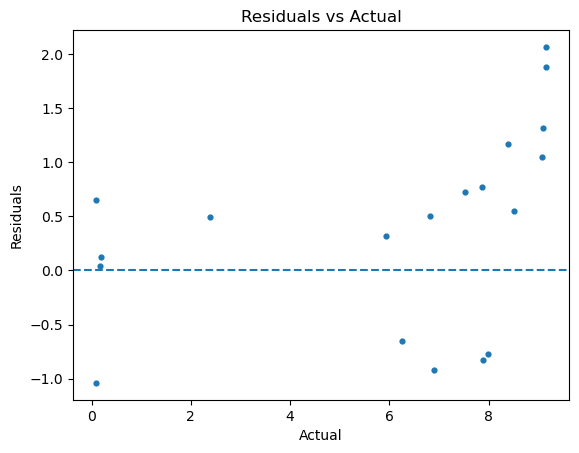

In [22]:
import matplotlib.pyplot as plt
plt.scatter(y_test_reg, y_test_reg - y_pred_reg, s=12)
plt.axhline(0, ls="--"); plt.xlabel("Actual"); plt.ylabel("Residuals"); plt.title("Residuals vs Actual")
plt.show()

In [23]:
model_reg.save("/Users/amlim/cycling-effectiveness/results/model_reg.h5")
model_clf.save("/Users/amlim/cycling-effectiveness/results/model_clf.h5")